## IBM Data Science Professional Certificate - Week 3
by Thiago Figueira

Today, we will explore and cluster the neighborhoods in **Toronto**. Since the data is not readily available in a neat dataframe, we have to collect it from the web and create our own. Luckily for us, Wikipedia has the data we need at: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In this notebook, we will

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 2>

1.  <a href="#item1">Acquire the Dataset</a>

2.  <a href="#item2">Acquire Neighborhood Coordinates</a>

3.  <a href="#item3">Explore and Cluster Neighborhoods</a>
    </font>
    </div>

## 1. Acquire the Dataset <a class="anchor" id="item1"></a>

In [15]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [16]:
# Download contents of the web page
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
data = requests.get(url).text

In [17]:
# Create BeautifulSoup object
soup = BeautifulSoup(data, 'html5lib')

In [18]:
# Get table
table = soup.find('table')

I understand that not all have contact with HTML or web development in general. For this reason, I created the chart below to demonstrate the essential structure of a HTML table:

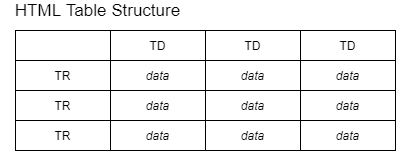

Observe that each *table row* (TD) has one or more *table data* (TD). However, our table has a different format: in each cell, the data is stacked.

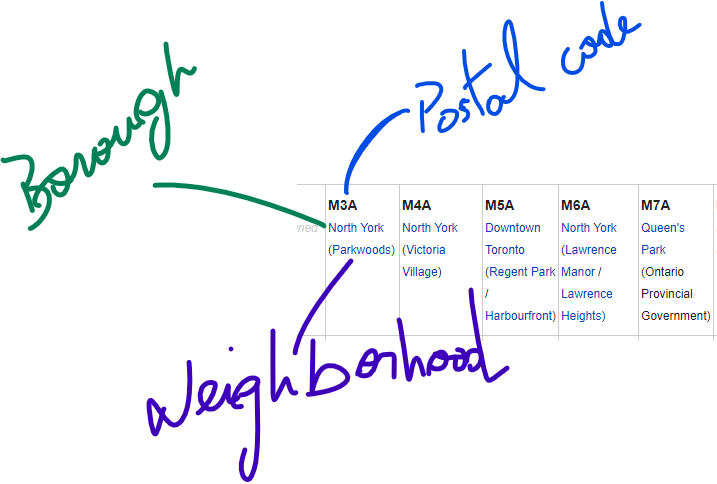


Hopefully this is help you understand the cell below

In [19]:
contents = []

# Get all rows
for row in table.find_all('td'):
    cell = {}
    if row.span.text == 'Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        contents.append(cell)

In [20]:
# Create dataframe
df = pd.DataFrame(contents)

# Change some values to more comprehensive names
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                     'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                     'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                     'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

# Visualize dataframe
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [21]:
print(df.shape)

(103, 3)


## 2. Acquire Neighborhood Coordinates <a class="anchor" id="item2"></a>

In [8]:
# Change the index of the dataframe to the PostalCode in a temporary df
temp_df = df.reset_index()
temp_df.drop(['index'], axis=1, inplace=True)
temp_df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [44]:
print(df[df['PostalCode'] == 'M1C'])

   PostalCode      Borough                            Neighborhood   Latitude  \
12        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   

    Longitude  
12 -79.160497  


In [48]:
import geocoder

def get_coordinates(address):  
    '''
    
    This function uses the geocoder api to find the 
    longitude and latitude of the given address
    
    Returns a tuple containing the latitude and longitude, in this order 
    
    '''
    
    lat_long_coordinates = None
    print(address)

    # Loop due to the unreliability of the api
    try:
        while (lat_long_coordinates is None):
            g = geocoder.geolytica('{}, Toronto, Ontario'.format(address))
            print(g.latlng)
            lat_long_coordinates = g.latlng
            
        return (lat_long_coordinates[0], lat_long_coordinates[1])
        
    except Exception as e:
        print('There was an error: ' + str(e))
        raise

The api did not respond after waiting for twenty minutes. Below is a screenshot of the error

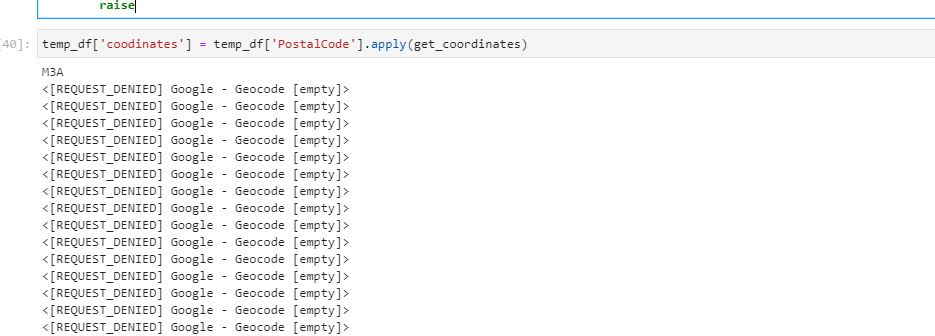

In [25]:
df_coordinates = pd.read_csv('Geospatial_Coordinates.csv')
df_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [31]:
df_coordinates.rename(columns={'Postal Code': 'PostalCode'})
df_coordinates.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [28]:
df = df.merge(df_coordinates, on='PostalCode')

In [30]:
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


## 3. Explore and Cluster Neighborhoods <a class="anchor" id="item3"></a>

In [52]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

We will visualize the neighborhoods on the map of Toronto.

In [57]:
toronto_latitude = 43.653226
toronto_longitude = -79.383184

map_toronto = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

We will analyze each neighborhoond and cluster them together.

In [ ]:
CLIENT_ID = '5F2FTW0TV13AX3NHBI1JICTRC3TMJNPLCBOSBENZGCXUFUTE' # your Foursquare ID
CLIENT_SECRET = '0YTG43CDIA2QAO2CPLCX0MFZ4O52XTZ3MYQKS5GGBPFDP5AM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [61]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [62]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [64]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [66]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,

In [103]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 4])

In [68]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [134]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Lounge,Breakfast Spot,Skating Rink,Clothing Store,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Gym,Playground,Pool,Coffee Shop,Pub,Yoga Studio,Mobile Phone Shop,Moroccan Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Restaurant,Ice Cream Shop,Sushi Restaurant,Fried Chicken Joint,Bridal Shop,Gas Station,Sandwich Place,Diner
3,Bayview Village,Japanese Restaurant,Café,Chinese Restaurant,Bank,Yoga Studio,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Comfort Food Restaurant,Indian Restaurant,Pizza Place,Pub,Café,Butcher


In [135]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.dropna(inplace=True)
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2.0,Fast Food Restaurant,Park,Food & Drink Shop,Yoga Studio,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Pizza Place,Financial or Legal Service,Intersection,Hockey Arena,Portuguese Restaurant,Coffee Shop,Yoga Studio,Mobile Phone Shop,Moroccan Restaurant,Monument / Landmark
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Park,Bakery,Breakfast Spot,Theater,Pub,Café,Chocolate Shop,Beer Store,French Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Clothing Store,Furniture / Home Store,Women's Store,Coffee Shop,Miscellaneous Shop,Boutique,Vietnamese Restaurant,Accessories Store,Park,Pet Store
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1.0,Coffee Shop,Sushi Restaurant,Yoga Studio,Japanese Restaurant,Burrito Place,Burger Joint,Smoothie Shop,Café,Spa,Fried Chicken Joint


In [136]:
toronto_merged['Cluster Labels'].isnull().sum()

0

In [137]:
# create map
kclusters = 5
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters